### utils 

In [8]:
from contentScoreShareUtils import * 

def add_timestamp_columns(stage1_raw):
    stage1_raw["date"] = stage1_raw["DateTime_UTC"].apply(lambda x: x[0:10]) ## 2022-11-01 00:00:02-06:00
    stage1_raw["hour"] = stage1_raw["DateTime_UTC"].apply(lambda x: x[11:13]) ## 2022-11-01 00:00:02-06:00
    # stage1_raw["minute"] = datetime.apply(lambda x: x.minute)
    return stage1_raw;

def convert_schema(stage1_raw):
    columns = pd.io.json.build_table_schema(stage1_raw)
    df_schema = {col["name"]:dtype_convert(col["type"]) for col in columns["fields"]}
    return df_schema

def dtype_convert(pandas_type):
    type = "Unknown"
    if pandas_type == "integer":
        type = INTEGER()
    elif pandas_type == "string":
        type = VARCHAR(255)
    elif pandas_type == "number":
        type = FLOAT(asdecimal=True)
    elif pandas_type == "boolean":
        type = BOOLEAN()
    return type

def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

def insert_with_progress(df, connection, table_name, insert_mode=False, dtype=None):
    chunksize = int(len(df) / 100) # 10%
    with tqdm(total=len(df)) as pbar:
        for i, cdf in enumerate(chunker(df, chunksize)):
            replace = "replace" if (i == 0 and insert_mode is False) else "append"
            cdf.to_sql(con=connection, name=table_name, dtype=dtype, if_exists=replace, index=False)
            pbar.update(chunksize)
                    
def load_csv_iter(glob_pattern="./target_mcvisid/*.csv"):
    files = sorted([file for file in glob(glob_pattern) if "aemRaw_keyColumns_2022" in file])
    for file in files:
        current = pd.read_csv(file)
        print("current file, ", file)
        yield file, current



### key filters 

In [9]:
def url_clean(x):
    x = re.sub(',|;', "", x) # clean special symbol
    x = re.sub("(#|.page|.aspx|.js|.php|adfs).*", "", x)  # clean tailing start with
    # x = re.sub("details.[\w-]*","details.{ID}", x) # grouping product details
    x = re.sub("com.cn", "com", x) # replace china area website URL
    # x = re.sub("%20", " ", x) # keep URL encoding
    
    # grouping different language
    x = re.sub("/$|(\.html)$|/[a-zA-Z]{2}$", "", x)  # remove html, etc /
    x = re.sub("/(global|go)/", "/", x)  
    x = re.sub(".com/[a-zA-Z]{2,3}/", ".com/", x)  
    x = re.sub("/[a-zA-Z]{2}[-_][a-zA-Z]{2,3}$", "", x)  # grouping homepage
    x = re.sub("/[a-zA-Z]{2}[-_][a-zA-Z]{2}[-_][a-zA-Z]{2}$", "", x)  # grouping search page
    x = re.sub("/[a-zA-Z]{2}[-_][a-zA-Z]{2,3}/|/[a-zA-Z]{2}/", "/", x)  # grouping different language
    
    return x

def url_filter(url_maps):
    url_maps = url_maps[(~url_maps["PageURL"].str.contains("file://.+")) & (url_maps["PageURL"].str.startswith("https://www.rockwellautomation"))] 
#     url_maps.query("('file://.+' not in PageURL) or https://www.rockwellautomation in PageURL") # query mode
    return url_maps
    
# x = "https://www.rockwellautomation.com/ja-jp/company/events/in-person-events/archive.html"
# x = "https://www.rockwellautomation.com/ja-jp/company/events/in-person-events/search/en-us-ab"
# x = "https://www.rockwellautomation.com/zh_TW"
# x = "https://www.rockwellautomation.com/hu-huhtml"
# x = "https://www.rockwellautomation.com/en-us/products/details.700-N400A1.html).html#adfdasf"
# x = "https://www.rockwellautomation.com/rockwellautomation/support/pcdc.page%7D%7D%7D/f0/fs20"
# x = "https://www.rockwellautomation.com/ja/fa.pagedfsdfa"
# x = "https://www.rockwellautomation.com/chl/overview.page"
# x = "https://www.rockwellautomation.com/adfs/oauth2/authorize"
# x = "https://www.rockwellautomation.com/en-nz/"
# url_clean(x)

'https://www.rockwellautomation.com'

### Config

In [ ]:
VERSION = "v1.2"
table_name = f"stage1_raw_{VERSION}"

refresh_table = True
mydb = create_engine('mysql+pymysql://rockwell:%s@localhost:3306/page_scoring' % quote('rockwell'))
testing = False
folder_dir = './aem_raw/'

### start ETL

#### define schema

In [3]:

schema = {'index': INTEGER(),
 'SessionVisitorId': VARCHAR(length=255),
 'VisitPageNumber': INTEGER(),
 'VisitNumber': INTEGER(),
 'NewVisit': BOOLEAN(),
 'EventList': VARCHAR(length=511),
 'DateTime_UTC': VARCHAR(length=255),
 'PageURL': VARCHAR(length=255),
 'VisitReferrer': VARCHAR(length=255),
 'VisitReferrerType': INTEGER(),
 'VisitorDomain': VARCHAR(length=255),
 'External_Audience': VARCHAR(length=255),
 'External_AudienceSegment': VARCHAR(length=255),
 'External_Industry': VARCHAR(length=255),
 'External_Website': VARCHAR(length=255),
 'EloquaContactId': VARCHAR(length=255),
 'EloquaGUID': FLOAT(asdecimal=True),
 'mcvisid': VARCHAR(length=255),
 'GeoCity': VARCHAR(length=255),
 'GeoCountry': VARCHAR(length=255),
 'GeoRegion': VARCHAR(length=255),
 'PDFurl': VARCHAR(length=255),
 'PDFpagecount': FLOAT(asdecimal=True),
 'BingeId': VARCHAR(length=255),
 'BingeCriticalScore': FLOAT(asdecimal=True),
 'BingeScoredAssetPath': VARCHAR(length=255),
 'BingeScoredAssetScore': FLOAT(asdecimal=True)}

#### batch processing

In [4]:
# aem_raw = load_csv_batches(glob_pattern="./aem_raw/*.csv", num=None, keep="last", iterator=False)
aem_raws = load_csv_iter(glob_pattern=folder_dir+"*.csv")

if refresh_table is True:
    with mydb.connect() as connection:
        connection.execute(f"""DROP TABLE IF EXISTS {table_name};""")

### preload data, could update as a query
email_mcvisid = pd.read_csv("mcvisid_elqid_email_all.csv")
email_mcvisid, drop_mcvisid = email_cleanup(email_mcvisid, "EmailAddress")
positive_mcvisid = email_mcvisid["mcvisid"].drop_duplicates() ## all along the past, if mcvisid existed with corresponding elqid, then it is positive sigal



logs = []
for idx, (file, aem_raw) in enumerate(aem_raws):
    log = []
    log.append(file)
    stage1_raw = aem_raw #.dropna(subset=["BingeScoredAssetPath"]).reset_index(drop=True)
    if idx < 1:
        df_schema = convert_schema(stage1_raw) if not schema else schema
        print(df_schema)
    row1 = stage1_raw.shape[0]
    print(f"original raw rows: {row1}")
    log.append(row1)

    stage1_raw = stage1_raw[~stage1_raw["mcvisid"].isin(drop_mcvisid["mcvisid"])] # drop irrelevant mcvisid
    row2 = stage1_raw.shape[0]
    print(f"Drop irrelevant mcvisid (testing emails) with rows: {row1 - row2}")
    log.append(row1 - row2)

    ## deduplicate with hour granularity
    print("start dedup with considering only unique records in hours granularity...")
    stage1_raw = add_timestamp_columns(stage1_raw)    
    stage1_raw = stage1_raw.drop_duplicates(subset=["mcvisid","date", "hour", "PageURL"], keep="first")
    row3 = stage1_raw.shape[0]
    print(f"""Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: {row2 - row3} ratio {(row2 - row3)/row2}""")
    log.append(row2 - row3)
    log.append((row2 - row3)/row2)

    ## get clean PageURL and drop irrelevant PageURL - inner join to drop unmatched rows
    url_maps = url_filter(stage1_raw[["PageURL"]].drop_duplicates())
    url_maps["clean_PageURL"] = url_maps["PageURL"].apply(lambda x: url_clean(x))
    # s = url_maps[url_maps["PageURL"].str.contains("details")].sample(100)
    stage1_raw = stage1_raw.merge(url_maps, on="PageURL")
    row4 = stage1_raw.shape[0]
    print(f"Drop irrelevant PageURL (by inner join) with rows: {row3 - row4}")
    log.append(row3 - row4)

    ## create labels
    stage1_raw["label"] = stage1_raw["mcvisid"].isin(positive_mcvisid) # mark pos and neg mcvisid
    row5 = stage1_raw.shape[0]
    print("stage1_raw: keep mcvisid rows: ", row5)
    print("stage1_raw: keep unique mcvisid: ", stage1_raw["mcvisid"].unique().shape[0])
    print("stage1_raw: keep unique pageURL: ", stage1_raw["clean_PageURL"].unique().shape[0])
    log.append(row5)
    log.append(stage1_raw["mcvisid"].unique().shape[0])
    log.append(stage1_raw["clean_PageURL"].unique().shape[0])
    
    try:
        insert_with_progress(stage1_raw, mydb, table_name=table_name, insert_mode=True, dtype=df_schema)
    except ValueError as vx:
        print(vx)
    except Exception as ex:
        print(ex)
    else:
        print("Table %s insert successfully." % table_name)
    
    logs.append(log)    
    if testing is True:
        break

with mydb.connect() as connection:
    connection.execute(f"""ALTER TABLE {table_name} ADD KEY(mcvisid(255));""")
    connection.execute(f"""ALTER TABLE {table_name} ADD KEY(EloquaContactId(255));""")

current file,  ./aem_raw/aemRaw_keyColumns_20220401-20220415.csv
{'index': INTEGER(), 'SessionVisitorId': VARCHAR(length=255), 'VisitPageNumber': INTEGER(), 'VisitNumber': INTEGER(), 'NewVisit': BOOLEAN(), 'EventList': VARCHAR(length=511), 'DateTime_UTC': VARCHAR(length=255), 'PageURL': VARCHAR(length=255), 'VisitReferrer': VARCHAR(length=255), 'VisitReferrerType': INTEGER(), 'VisitorDomain': VARCHAR(length=255), 'External_Audience': VARCHAR(length=255), 'External_AudienceSegment': VARCHAR(length=255), 'External_Industry': VARCHAR(length=255), 'External_Website': VARCHAR(length=255), 'EloquaContactId': VARCHAR(length=255), 'EloquaGUID': FLOAT(asdecimal=True), 'mcvisid': VARCHAR(length=255), 'GeoCity': VARCHAR(length=255), 'GeoCountry': VARCHAR(length=255), 'GeoRegion': VARCHAR(length=255), 'PDFurl': VARCHAR(length=255), 'PDFpagecount': FLOAT(asdecimal=True), 'BingeId': VARCHAR(length=255), 'BingeCriticalScore': FLOAT(asdecimal=True), 'BingeScoredAssetPath': VARCHAR(length=255), 'BingeS

1319666it [01:32, 14304.03it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220415-20220430.csv
original raw rows: 5235230
Drop irrelevant mcvisid (testing emails) with rows: 276607
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 3563994 ratio 0.7187467165783726
Drop irrelevant PageURL (by inner join) with rows: 52367
stage1_raw: keep mcvisid rows:  1342262
stage1_raw: keep unique mcvisid:  689118
stage1_raw: keep unique pageURL:  263823


1355622it [01:38, 13695.28it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220501-20220515.csv
original raw rows: 5495277
Drop irrelevant mcvisid (testing emails) with rows: 351812
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 4163824 ratio 0.8095367616966384
Drop irrelevant PageURL (by inner join) with rows: 36675
stage1_raw: keep mcvisid rows:  942966
stage1_raw: keep unique mcvisid:  366467
stage1_raw: keep unique pageURL:  24130


952329it [01:09, 13750.62it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220515-20220531.csv
original raw rows: 6413570
Drop irrelevant mcvisid (testing emails) with rows: 398732
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 4901685 ratio 0.8149321727368218
Drop irrelevant PageURL (by inner join) with rows: 39072
stage1_raw: keep mcvisid rows:  1074081
stage1_raw: keep unique mcvisid:  408249
stage1_raw: keep unique pageURL:  23598


1084740it [01:15, 14424.51it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220601-20220615.csv
original raw rows: 5490207
Drop irrelevant mcvisid (testing emails) with rows: 331552
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 4339802 ratio 0.8412661827550011
Drop irrelevant PageURL (by inner join) with rows: 39825
stage1_raw: keep mcvisid rows:  779028
stage1_raw: keep unique mcvisid:  296519
stage1_raw: keep unique pageURL:  20613


786790it [00:55, 14162.39it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220615-20220630.csv
original raw rows: 2997171
Drop irrelevant mcvisid (testing emails) with rows: 196137
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 2624213 ratio 0.9368729547731303
Drop irrelevant PageURL (by inner join) with rows: 43507
stage1_raw: keep mcvisid rows:  133314
stage1_raw: keep unique mcvisid:  74084
stage1_raw: keep unique pageURL:  165


134633it [00:09, 14043.30it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220701-20220715.csv
original raw rows: 4322589
Drop irrelevant mcvisid (testing emails) with rows: 229350
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 3592882 ratio 0.8777601307912878
Drop irrelevant PageURL (by inner join) with rows: 38013
stage1_raw: keep mcvisid rows:  462344
stage1_raw: keep unique mcvisid:  205315
stage1_raw: keep unique pageURL:  13698


466923it [00:32, 14333.95it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220715-20220731.csv
original raw rows: 3680306
Drop irrelevant mcvisid (testing emails) with rows: 209329
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 3087756 ratio 0.8895927573129986
Drop irrelevant PageURL (by inner join) with rows: 50801
stage1_raw: keep mcvisid rows:  332420
stage1_raw: keep unique mcvisid:  217731
stage1_raw: keep unique pageURL:  3788


335724it [00:22, 15230.32it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220801-20220815.csv
original raw rows: 4565584
Drop irrelevant mcvisid (testing emails) with rows: 225676
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 3708392 ratio 0.8544863162997925
Drop irrelevant PageURL (by inner join) with rows: 36363
stage1_raw: keep mcvisid rows:  595153
stage1_raw: keep unique mcvisid:  305846
stage1_raw: keep unique pageURL:  15452


601051it [00:40, 14817.02it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220815-20220831.csv
original raw rows: 8746625
Drop irrelevant mcvisid (testing emails) with rows: 449514
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 7084384 ratio 0.8538374381155079
Drop irrelevant PageURL (by inner join) with rows: 26845
stage1_raw: keep mcvisid rows:  1185882
stage1_raw: keep unique mcvisid:  499031
stage1_raw: keep unique pageURL:  23965


1197658it [01:26, 13775.11it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220901-20220915.csv
original raw rows: 7084004
Drop irrelevant mcvisid (testing emails) with rows: 383296
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 5736282 ratio 0.8560710301060723
Drop irrelevant PageURL (by inner join) with rows: 7516
stage1_raw: keep mcvisid rows:  956910
stage1_raw: keep unique mcvisid:  416858
stage1_raw: keep unique pageURL:  22370


966469it [01:08, 14047.64it/s]                                                  


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20220915-20220930.csv
original raw rows: 7222517
Drop irrelevant mcvisid (testing emails) with rows: 418310
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 5623244 ratio 0.8264363503344327
Drop irrelevant PageURL (by inner join) with rows: 12230
stage1_raw: keep mcvisid rows:  1168733
stage1_raw: keep unique mcvisid:  481827
stage1_raw: keep unique pageURL:  23283


1180387it [01:22, 14356.97it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20221001-20221015.csv
original raw rows: 6240070
Drop irrelevant mcvisid (testing emails) with rows: 370816
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 4771402 ratio 0.8129486302688553
Drop irrelevant PageURL (by inner join) with rows: 11134
stage1_raw: keep mcvisid rows:  1086718
stage1_raw: keep unique mcvisid:  445014
stage1_raw: keep unique pageURL:  23098


1097567it [01:17, 14164.83it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20221015-20221031.csv
original raw rows: 6988682
Drop irrelevant mcvisid (testing emails) with rows: 344546
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 5570933 ratio 0.838473655566352
Drop irrelevant PageURL (by inner join) with rows: 10378
stage1_raw: keep mcvisid rows:  1062825
stage1_raw: keep unique mcvisid:  447921
stage1_raw: keep unique pageURL:  23141


1073428it [01:15, 14262.96it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20221101-20221115.csv
original raw rows: 7904562
Drop irrelevant mcvisid (testing emails) with rows: 411787
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 6329490 ratio 0.8447457717601289
Drop irrelevant PageURL (by inner join) with rows: 14374
stage1_raw: keep mcvisid rows:  1148911
stage1_raw: keep unique mcvisid:  462094
stage1_raw: keep unique pageURL:  25632


1160389it [01:18, 14719.28it/s]                                                 


Table stage1_raw insert successfully.
current file,  ./aem_raw/aemRaw_keyColumns_20221115-20221130.csv
original raw rows: 7898931
Drop irrelevant mcvisid (testing emails) with rows: 344666
start dedup with considering only unique records in hours granularity...
Drop duplicate rows by ["mcvisid","date", "hour", "PageURL"]: 6389764 ratio 0.8458485372170556
Drop irrelevant PageURL (by inner join) with rows: 8971
stage1_raw: keep mcvisid rows:  1155530
stage1_raw: keep unique mcvisid:  469041
stage1_raw: keep unique pageURL:  26315


1167055it [01:20, 14507.73it/s]                                                 


Table stage1_raw insert successfully.


#### logs

In [5]:
logs_df = pd.DataFrame(logs, columns=[
            "file",
            "original raw rows",
            "Drop irrelevant mcvisid (testing emails) with rows",
            "Drop duplicate rows by ['mcvisid','date', 'hour', 'PageURL']",
            "Drop duplicate rows by ['mcvisid','date', 'hour', 'PageURL'] ratio",
            "Drop irrelevant PageURL (by inner join) with rows",
            "After ETL keep mcvisid rows",
            "After ETL keep unique mcvisid",
            "After ETL keep unique pageURL",])

logs_df.to_excel(f"{table_name}_table_ETL_logs.xlsx")

url_maps["isChanged"] = url_maps["clean_PageURL"]!=url_maps["PageURL"]
url_maps.to_csv("clean_PageURL_checking.csv", encoding='utf-8')

### retrieve and store in local

In [7]:
usecols = [
    "mcvisid", "clean_PageURL", "label", "PDFurl", "BingeScoredAssetPath", "BingeId", "date", "hour",
    "VisitReferrer", "VisitorDomain", 'External_Audience',
    'External_AudienceSegment', 'External_Industry', 'External_Website',
    "EloquaContactId", "PageURL"
]

In [8]:
# table_name = "stage1_raw"
mydb = create_engine('mysql+pymysql://rockwell:%s@localhost:3306/page_scoring' % quote('rockwell'))
    
with mydb.connect() as connection:
    stage1_raw_2 = pd.read_sql_query(f'SELECT {", ".join(usecols)} FROM {table_name}',connection)
    
stage1_raw_2.to_csv(f"stage1_raw_{VERSION}.csv")

### conversion ratio

In [140]:
# stage1_raw_2 = pd.read_csv(f"stage1_raw_{VERSION}.csv", nrows=None)
aem_raw = stage1_raw_2
aem_raw = aem_raw[aem_raw["date"]>"2022-10-01"] ## should be done on query part to reduce memory consumption

view3 = aem_raw.groupby("clean_PageURL")["mcvisid"].count().rename("page_visit_count").to_frame()
stopwords = view3[view3["page_visit_count"]>100000].sort_values("page_visit_count") # stopwords
stopwords.to_excel(f"high_frequency_pages_{VERSION}.xlsx")

#### preload

In [21]:
email_mcvisid = pd.read_csv("mcvisid_elqid_email_all.csv")
email_mcvisid, drop_mcvisid = email_cleanup(email_mcvisid, "EmailAddress")

_lead = pd.read_csv("crm_Lead_20221116_all.csv", index_col=0)
crm_lead, drop_rows = email_cleanup(_lead, "emailaddress1")

#### define positive signal

In [141]:
statecodename_positive_rules = {"Qualified": 1}
statuscodename_positive_rules = {"Already Active Opportunity": 1, "Assigned to Distribution":1}
crm_lead["statecode_signal"] = crm_lead["statecodename"].map(statecodename_positive_rules).fillna(0)
crm_lead["statuscode_signal"] = crm_lead["statuscodename"].map(statuscodename_positive_rules).fillna(0)

def label_assign_rules(x):
    target_cols = x[["statuscode_signal", "statecode_signal"]]
    is_positive = target_cols.sum().sum()>0 # one of them is positive
    return is_positive

email_updated_label = crm_lead.groupby("emailaddress1").apply(lambda x: label_assign_rules(x))
email_updated_label = email_updated_label.reset_index()
email_updated_label.columns = ["EmailAddress", "label"]

mcvisid_labels = email_mcvisid.merge(email_updated_label, on="EmailAddress", how="left")
mcvisid_labels["label"].fillna(False, inplace=True)
positive_mcvisid = mcvisid_labels[mcvisid_labels["label"] == True]["mcvisid"]
updated_labels = mcvisid_labels[["mcvisid","label"]].drop_duplicates()

In [142]:
stage1_raw = aem_raw.drop(columns=["label"]).merge(updated_labels, on="mcvisid", how="left") # drop no valid mcvisid
print(stage1_raw["label"].fillna("nan").value_counts())
# stage1_raw["label"] = stage1_raw["label"].fillna(False)
stage1_raw.dropna(subset=["label"], inplace=True)
print(stage1_raw["label"].fillna("nan").value_counts())
stage1_raw.to_csv("model_input_EDA" + "_"+VERSION)
stage1_raw = stage1_raw[~stage1_raw["clean_PageURL"].isin(stopwords.index)] ## drop stopwords
print("after drop high freq website:\n", stage1_raw["label"].fillna("nan").value_counts())

nan      3546400
False     831349
True       52446
Name: label, dtype: int64
False    831349
True      52446
Name: label, dtype: int64
after drop high freq website:
 False    550522
True      33645
Name: label, dtype: int64


In [143]:
total = stage1_raw.groupby("clean_PageURL").size().rename("total")
pos = stage1_raw.groupby("clean_PageURL")["label"].sum().rename("positive") * 1
result = pd.concat([total, pos], axis=1)
result["ratio"] = result["positive"]/result["total"]
result["negative"] = (result["total"] - result["positive"])*1

In [144]:
result.to_excel(f"result_{VERSION}.xlsx")

#### assign score

In [145]:
# def assign_score(row):
#     if 10000<row["total"] || row["total"]>50:
#         return 1
#     else:

In [146]:
plot_data = result.query("10000>`total`>50 and `ratio`>0.05")
x = plot_data["ratio"].astype(float)

### min-max
# x = (x-x.min())/(x.max()-x.min()) * 5

### z-score
# x = ((x-x.mean())/x.std())

index = plot_data.assign(clean_PageURL=lambda x: x.index)["clean_PageURL"]

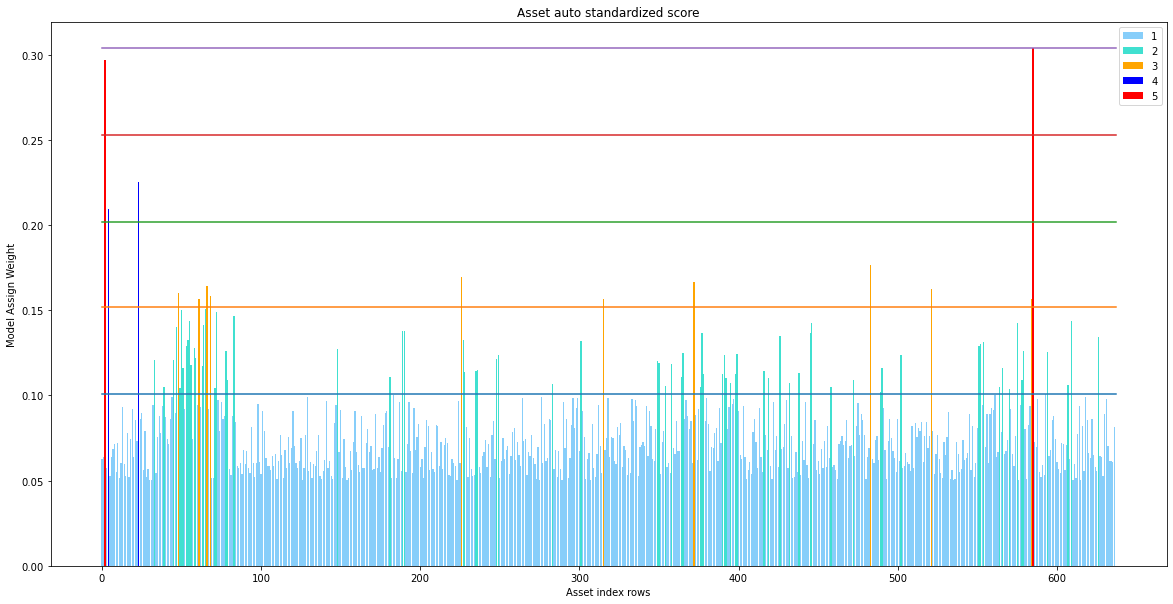

In [152]:
xx = score_bar_plot(index, x, num_levels = 5)

In [155]:
xx[xx["auto_score"]>1].sort_values(by="auto_score", ascending=False).style

,clean_PageURL,asset,weight,bins,color,auto_score
2,https://www.rockwellautomation.com/capabilities/connected-enterprise/management-perspectives,https://www.rockwellautomation.com/capabilities/connected-enterprise/management-perspectives,0.296875,"[0.253, 0.304]",red,5
585,https://www.rockwellautomation.com/products/software/rockwell-software,https://www.rockwellautomation.com/products/software/rockwell-software,0.303951,"[0.253, 0.304]",red,5
23,https://www.rockwellautomation.com/capabilities/industrial-safety-solutions/risk-assess-software-tool,https://www.rockwellautomation.com/capabilities/industrial-safety-solutions/risk-assess-software-tool,0.225352,"[0.202, 0.253]",blue,4
4,https://www.rockwellautomation.com/capabilities/digital-transformation,https://www.rockwellautomation.com/capabilities/digital-transformation,0.209677,"[0.202, 0.253]",blue,4
315,https://www.rockwellautomation.com/products/hardware/allen-bradley/drives/low-voltage-ac-drives/architecture-drives/20d-powerflex-700s,https://www.rockwellautomation.com/products/hardware/allen-bradley/drives/low-voltage-ac-drives/architecture-drives/20d-powerflex-700s,0.156627,"[0.152, 0.202]",orange,3
521,https://www.rockwellautomation.com/products/hardware/allen-bradley/safety-products/safety-sensors/safety-interlock-switches/non-contact-interlock-switches/440n-ferrogard-1--2--20--21,https://www.rockwellautomation.com/products/hardware/allen-bradley/safety-products/safety-sensors/safety-interlock-switches/non-contact-interlock-switches/440n-ferrogard-1--2--20--21,0.162500,"[0.152, 0.202]",orange,3
66,https://www.rockwellautomation.com/company/events/webinars/technology-partner-genius-webinar-with-spectrum-controls,https://www.rockwellautomation.com/company/events/webinars/technology-partner-genius-webinar-with-spectrum-controls,0.164213,"[0.152, 0.202]",orange,3
68,https://www.rockwellautomation.com/company/events/webinars/thingworx-fundamentals--your-iiot-platform,https://www.rockwellautomation.com/company/events/webinars/thingworx-fundamentals--your-iiot-platform,0.158192,"[0.152, 0.202]",orange,3
372,https://www.rockwellautomation.com/products/hardware/allen-bradley/industrial-control-products/line-load-power-solutions,https://www.rockwellautomation.com/products/hardware/allen-bradley/industrial-control-products/line-load-power-solutions,0.166667,"[0.152, 0.202]",orange,3
584,https://www.rockwellautomation.com/products/software/factorytalk/whats-new,https://www.rockwellautomation.com/products/software/factorytalk/whats-new,0.156627,"[0.152, 0.202]",orange,3


In [153]:
xx.shape

(637, 6)

### post to AEM